# Sequencer Fee Contributors

###  Draft RPGF3 List ✨

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-10-31_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "ProjectSequencerFees"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-01_SequencerFeeContributors.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list only considers projects with onchain activity on OP Mainnet."
                "The list identifies the total amount of sequencer fees generated by all of a project's",
                "smart contracts. It allocates a pool of tokens pro rata based on each project's",
                "sequencer fee contributions."
            ])
LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            #'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            #'OP_STACK'
            ]

AWARD_AMT = 50000000

JSON_PATH = DATA_DIR + LIST_NAME + ".json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
print()

oso.check_duplicate_slugs()

Loaded 360 OSS projects from data/RPGF3/2023-10-31_RPGF3_cleaned_applicant_data.json.
Identified 336 unique slugs.



,Project Name,Slug: Primary,Payout Address
85,Abhinav,awesome-optimism-lucas-op,0x23583685Ff8d24cD53B9809D2686fB03746E069e
217,Awesome Optimism,awesome-optimism-lucas-op,0x82aCDE34C057B009041B030f34F03a11f50735bf
340,Bankless DAO,banklessdao,0x918cEB96DeEaBa2Db06b18d7FC8F52FE0a206040
285,jengajojo,banklessdao,0x918ceb96deeaba2db06b18d7fc8f52fe0a206040
330,International Media Nodes (IMN),banklessdao,0x918cEB96DeEaBa2Db06b18d7FC8F52FE0a206040
121,ERC1155 Bridge,bootnodedev,0x6b10D7Fc3774431aDD486265a9049e4c9b7eFE5B
152,Bedrock Contracts Architecture Diagram,bootnodedev,0x6b10D7Fc3774431aDD486265a9049e4c9b7eFE5B
251,Randomness Ceremony,filosofiacodigo,0xFe568475CFc25563B5A5E9769f56b61dF85e7Dec
134,FilosofiaCodigo,filosofiacodigo,0xb6F5414bAb8d5ad8F33E37591C02f7284E974FcB
153,Gitcoin Passport,gitcoin,0x16883ef6737bd243BB638Bd09b0C31c47F34D258


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)
type_id = 26 # CONTRACT_INVOCATION_DAILY_FEES

query = f"""
    SELECT
        p.slug,
        sum(e.amount)
    FROM
        event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        p.slug IN ('{slugs_list}')
        AND e."typeId" = {type_id}
    GROUP BY
        p.slug;
"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

contributions = {project: round(amount / 10e17,4) for (project, amount) in results}
contributions

{'across': 3.8713,
 'acrypto-s': 0.0002,
 'another-world': 0.0847,
 'aw-labs': 0.0131,
 'cliqueofficial': 0.0,
 'coordinape': 0.4395,
 'dapp-learning-dao': 0.0003,
 'decent': 0.0002,
 'defi-llama': 0.2385,
 'delegatexyz': 0.0,
 'dforce-network': 0.1602,
 'dm3-protocol': 0.0,
 'eco-association': 0.0,
 'eth-infinitism-account-abstraction': 0.3751,
 'ethereum-attestation-service': 0.4077,
 'flipside-crypto': 0.0053,
 'galxe': 0.0952,
 'gelato': 1.9303,
 'geo-web': 0.0,
 'gitcoin': 1.1048,
 'grateful-protocol': 0.0,
 'hats-protocol': 0.0,
 'hausdao': 0.0,
 'holonym-foundation': 2.0523,
 'hop-protocol': 0.2597,
 'hypercerts': 0.4383,
 'idriss-crypto': 0.0,
 'kiwi-news-attestate': 0.0,
 'kromatika-finance': 0.1203,
 'kwenta': 17.2013,
 'lyra-finance': 6.6292,
 'metadexa': 0.0002,
 'mirror': 0.0369,
 'nftearth': 0.0011,
 'openocean-finance': 0.0027,
 'pheasant-network': 0.0002,
 'polynomial-protocol': 0.5418,
 'punk-domains': 0.0003,
 'pyth-network': 0.0043,
 'rabbithole': 0.0978,
 'rainbow':

# Generate the list

In [6]:
named_list = listify(contributions, AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

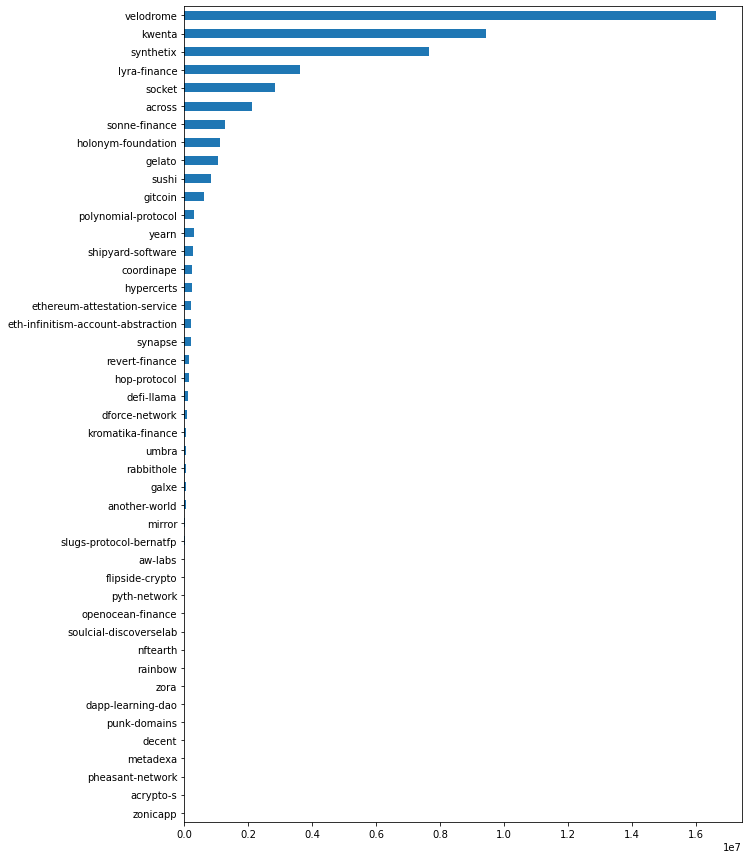

In [7]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)